# **Aprendizaje supervisado**

*Nuestra tarea consiste en predecir el valor medio de las viviendas en los distritos californianos, dada una serie de características de estos distritos. Se trata de una regresión, ya que se le pide al modelo que prediga un valor. Ya que el sistema va a utilizar varias características para hacer la predicción es un problema de regresión múltiple.*

**Etapas**:
* Obtención de los datos
* Estudio de los datos
* Descubriendo y visualizando datos
* Preparando los datos para el modelo
* Seleccionar los modelos y entrenarlos
* Evaluar los resultados



# Inicio

En primer lugar, vamos a importar algunos módulos comunes, asegurarnos de que MatplotLib traza las figuras correctamente y preparar una función para guardar las figuras. También comprobamos que Python 3.5 o posterior está instalado (aunque Python 2.x puede funcionar, está obsoleto por lo que es **altamente** recomendable utilizar Python 3 en su lugar), así como Scikit-Learn ≥0.20.

In [1]:
# Se requiere Python ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Se requiere Scikit-Learn ≥ 0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Otros imports
import numpy as np
import os;

# lo que sigue, sólo en Google Colab
#%matplotlib inline

# Más imports
import matplotlib as mpl
import matplotlib.pyplot as plt

# tamaño del texto en las etiquetas por defecto
mpl.rc('axes',  labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Obteniendo los datos

## Descargando los datos

Los datos vamos a descargarlos desde un servicio remoto. El github de Aurélien Gerón, autor del libro "*Aprende Machine Learning con Scikit-Learn, Keras y Tensorflow*".

In [2]:
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# esta función descarga y descomprime los datos desde una url a un directorio
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# Y llamamos a la función recién creada para descargar los datos
fetch_housing_data()

C:\Users\constantin.madalin.i\AppData\Local\Temp\ipykernel_7724\1734106033.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [4]:
import pandas as pd

# Creamos una función que lee el fichreo .csv que acabamos de bajar y descomprimir

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


## Primer acercamiento a la estructura de los datos

Cargamos los datos en memoria y hacemos un primer análisis.

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observa arriba

* Tenemos columnas con datos **null**: $total\_bedrooms$ tiene menos datos *non-null* que el resto.
* La columna $ocean\_proximity$ no es de tipo numérico (tipo $string$).

Vamos a mirar en esta última, el número de valores distintos.

In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Respecto al resto de columnas, vamos a describirlas mediante un análisis estadístico simple.

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Finalmente, para este apartado, vamos a visualizar la distribución de los valores de las columnas numéricas. 

Observa los picos *extraños*. Además los atributos tienen escalas muy diferentes. Los ingresos *incomes* están en miles de $ (p.e. 1=10000 dólares)

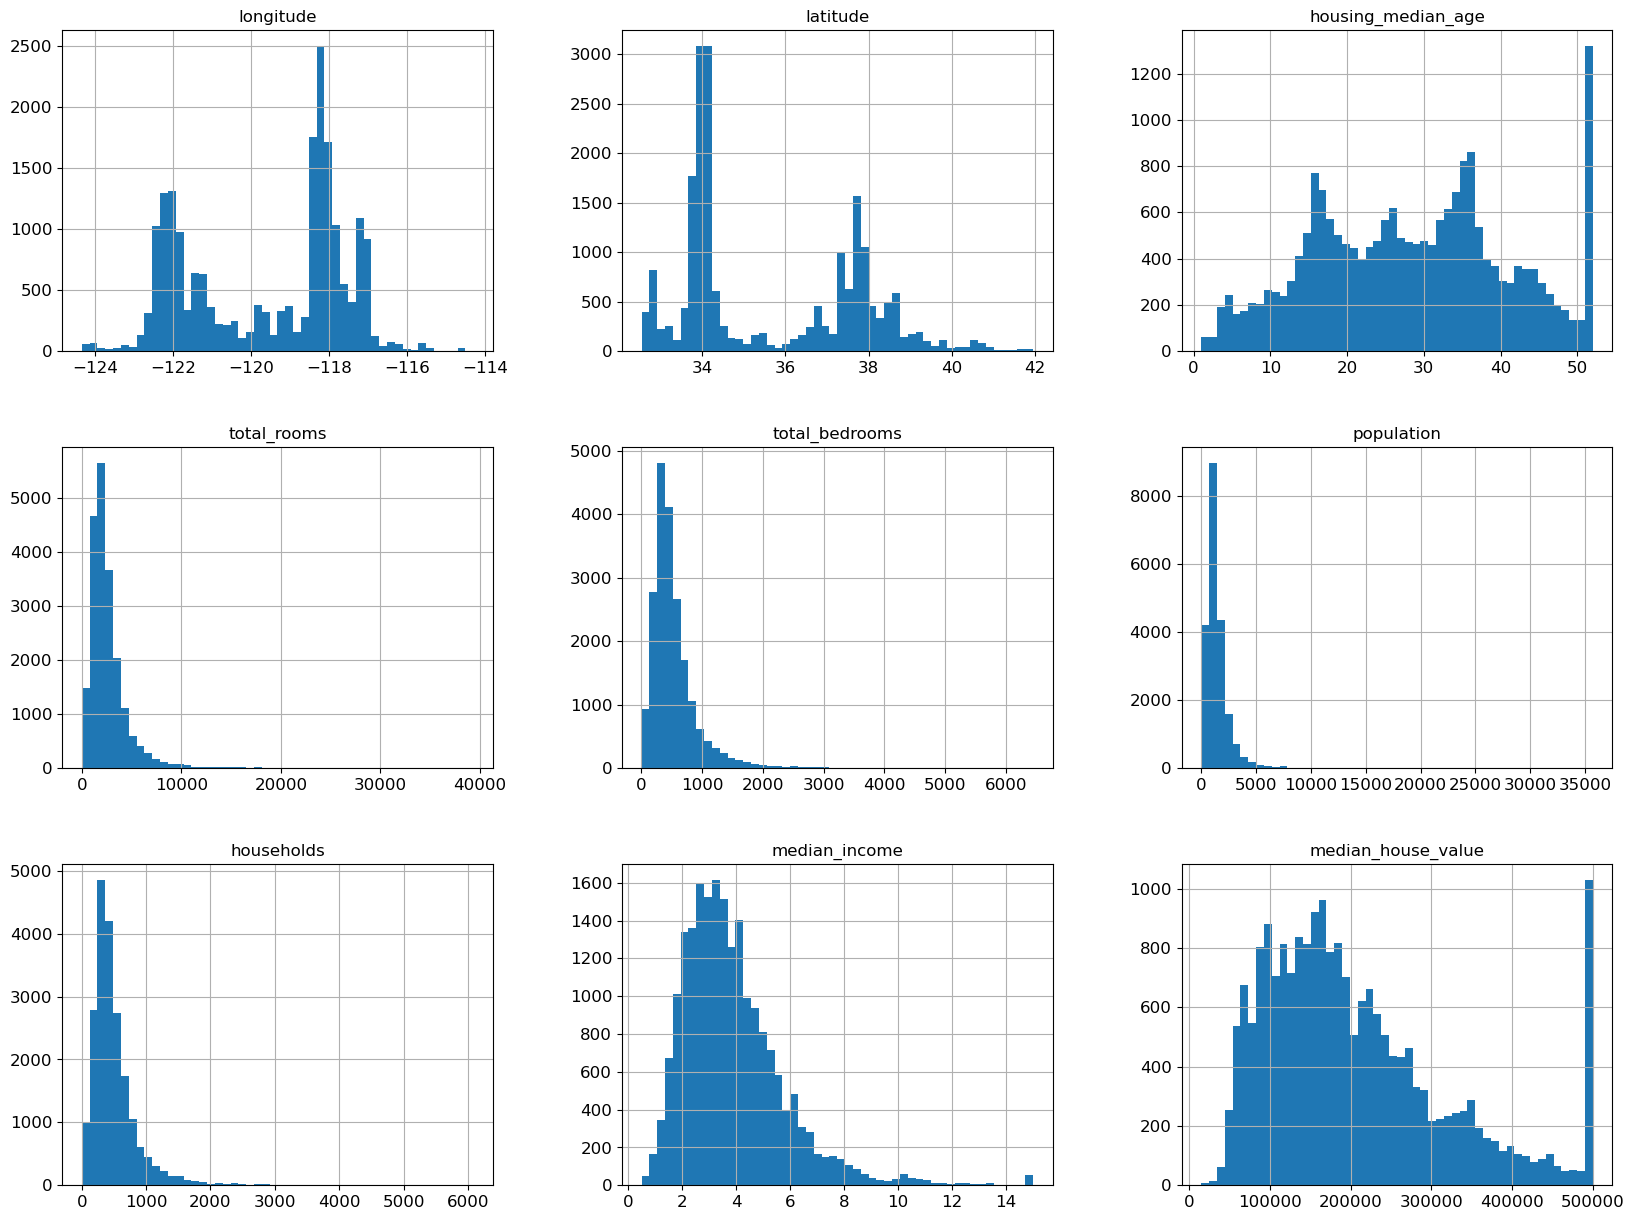

In [9]:
housing.hist(bins=50, figsize=(20,15))  
plt.show()

Vemos gráficas con sesgos a la derecha, así que habrá que realizar alguna transformación para evitarlos
Vemos también que hay una clara relación entre ingresos medios (median_income) y precio medio de las viviendas

# Descubriendo y visualizando los datos

## Visualizando datos geográficos

Simplemente vamos a hacer una gráfica de tipo $scatter$ (diagrama de dispersión) de las columnas longitud y latitud. 

<Axes: xlabel='longitude', ylabel='latitude'>

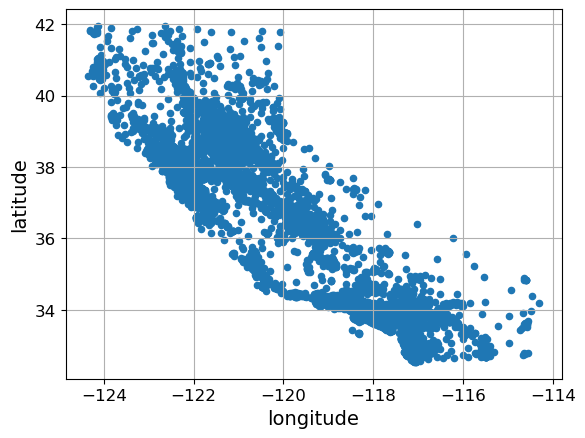

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude",grid=True)


Para visualizar un poco mejor las diferentes densidades de los datos geogŕficos, vamos a darle un poco de transparencia a los puntos.

<Axes: xlabel='longitude', ylabel='latitude'>

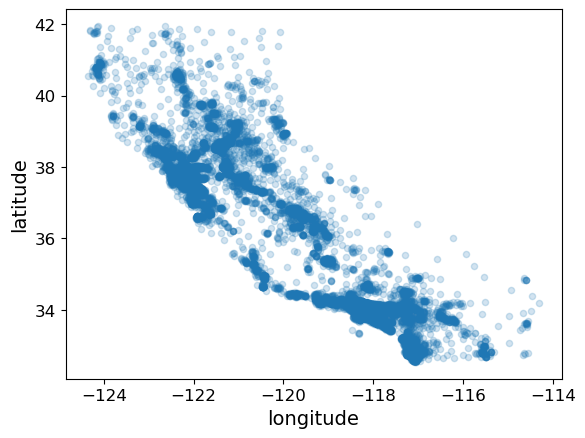

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)

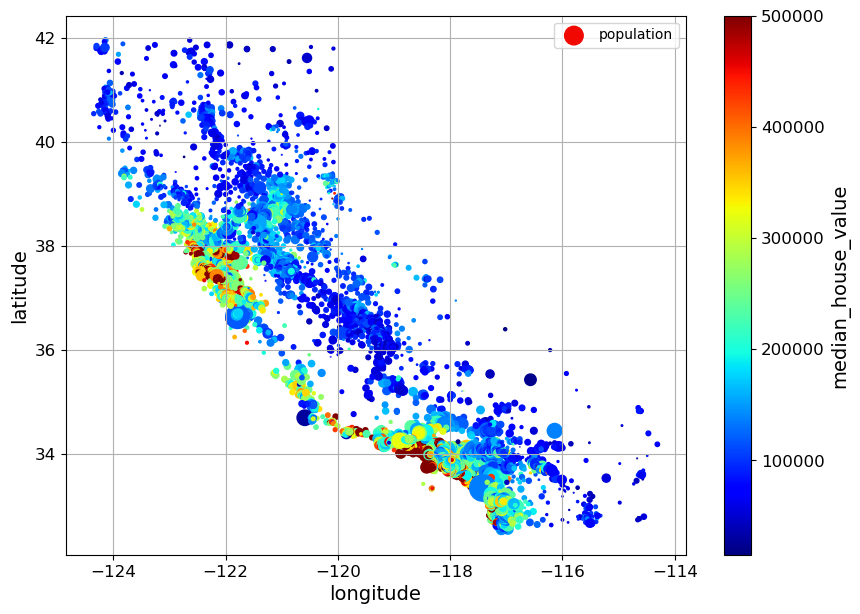

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

plt.show()

Vamos a superponer los datos sobre un mapa real de la zona, ya que sabemos que es California y los datos están indexados en coordenadas geográficas (long/lat).


Lo siguiente si lo cargas desde VSCode con fichero local:

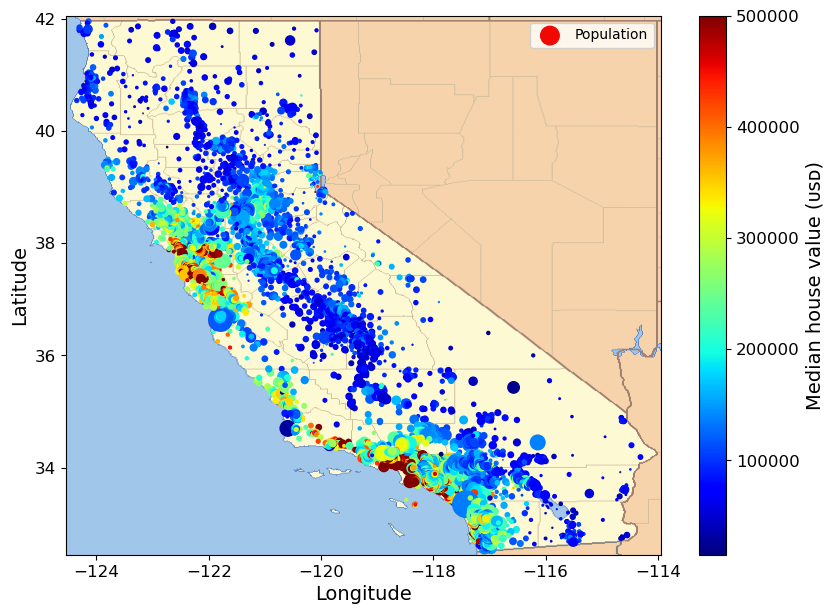

In [13]:
filename = "california.png"
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population", #tamaño del punto: +grande>población
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,  #utiliza color y una escala de colores
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)


plt.show()

Si lo cargas desde el github de Aurélien:

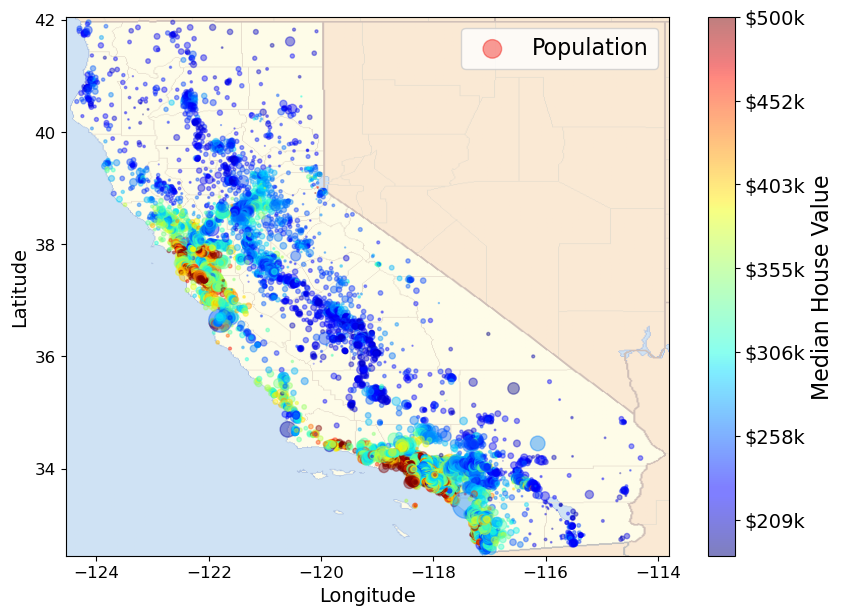

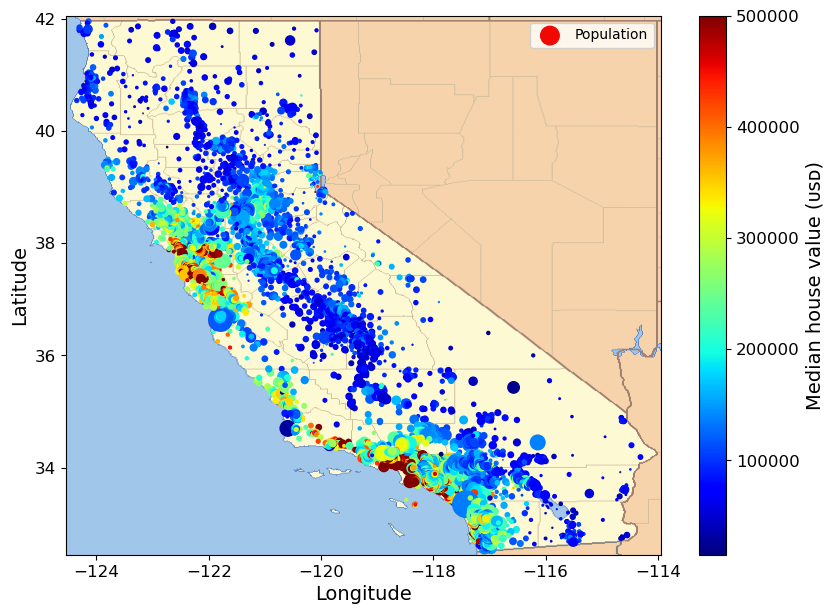

In [14]:

images_path = os.path.join(".", "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()


housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)


plt.show()

## A la búsqueda de Correlaciones 

Coeficiente de correlación:

- Correlaciones fuertes: [-1.0,-0,7], [0,7,1.0]

- Correlaciones débiles: [-0.3,0.3]

- Correlación fuerte: 1 (aumentan o disminuyen de manera exacta), -1 (aumentan o disminuyen en dirección opuesta)

- No correlacionadas: 0

De momento vamos a centrarnos en las columnas numéricas, más adelante veremos qué hacemos con la proximidad al océano


In [15]:
corr_matrix = housing.corr(numeric_only=True)

Centrémonos en las correlaciones de la columna a predecir ($median\_house\_value$) con el resto de columnas numéricas.

In [16]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Miremos con más detenimiento la correlación del valor medio de las casas, con los ingresos medios de la zona(*median_income*). Hay una clara correlación (~0.7), aunque no una identidad (1).

Podemos utilizar también la scatter_matrix de pandas

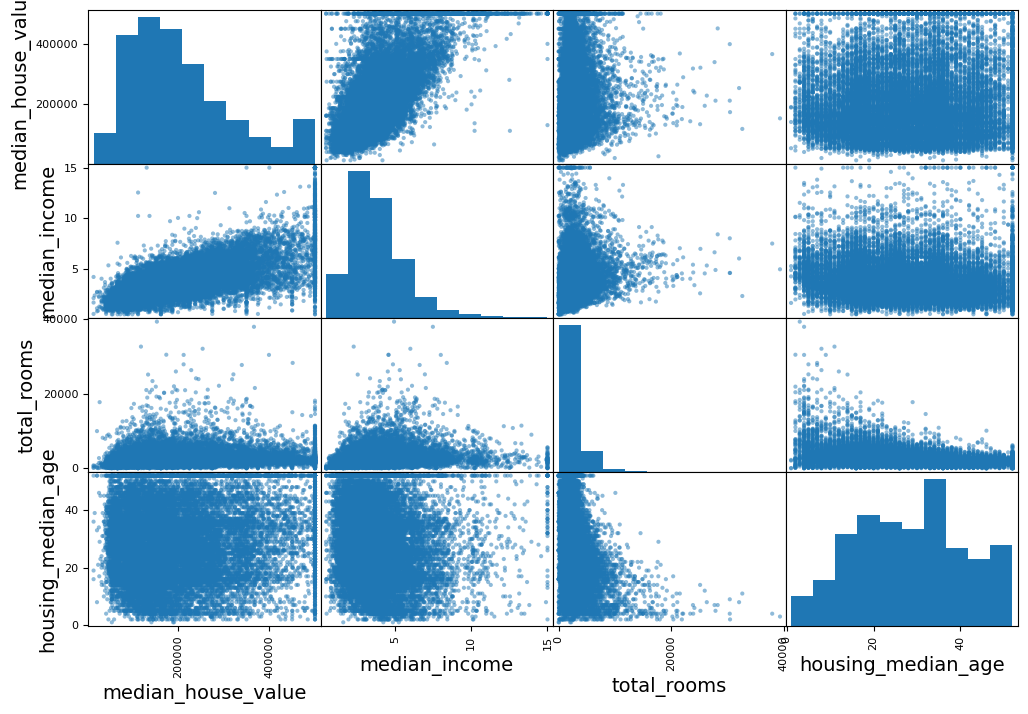

In [17]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()


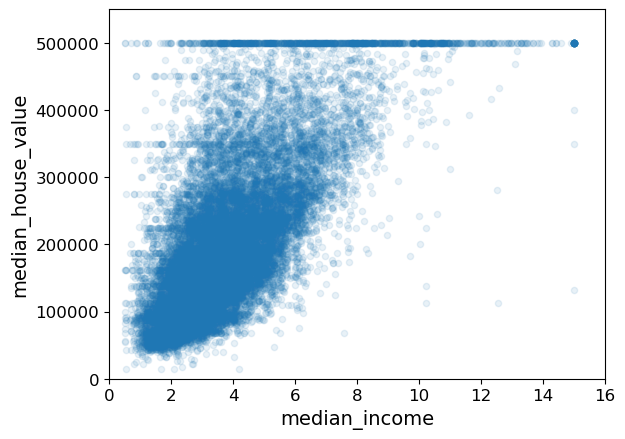

In [18]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

Tendencia ascendente y puntos no demasiado dispersos. Hay algunas rectas evidentes: la superior(techo: si superan ese valor van todos aquí)  pero también alguna en 450.000 otra en 350.000, sería quizás interesante eliminar los distritos correspondientes para evitar que los algoritmos aprendan a reproducir esas singularidades en los datos.

## Experimentando con operaciones con columnas

Siempre podemos buscar correlaciones en los datos pero pueden aparecer cuando combinamos una o más de las características en expresiones aritméticas. [Por ejemplo, la población/viviendas sí puede decirnos algo sobre el precio de la vivienda]
Creamos esas nuevas columnas.

In [19]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [20]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

Fíjate:
* Ha aparecido $rooms\_per\_household$ con un índice de correlación superior al de sus precursoras. Claro, cuanto más grandes las casas, más caras.
* $bedrooms\_per\_room$ igualmente ha emergido con un índice de correlación alto y negativo.

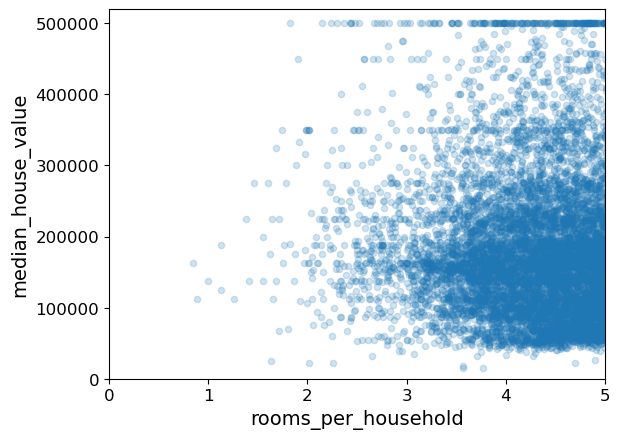

In [21]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

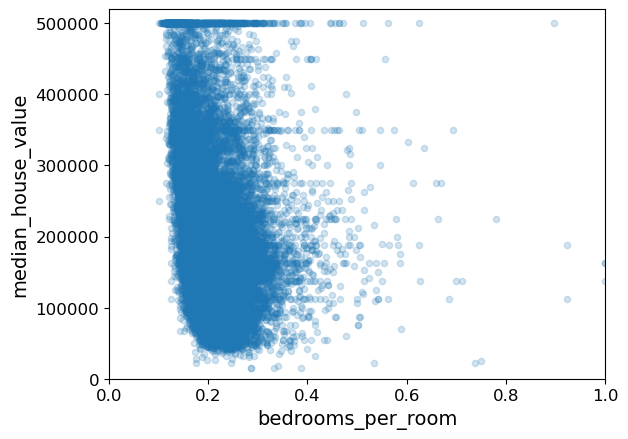

In [22]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value", alpha=0.2)
plt.axis([0, 1, 0, 520000])
plt.show()

In [23]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Preparando los datos para el entrenamiento del modelo

Parece que $median\_income$ , que representa los ingresos medios de los habitantes de la zona, es importante para predecir los precios de las casas

<Axes: >

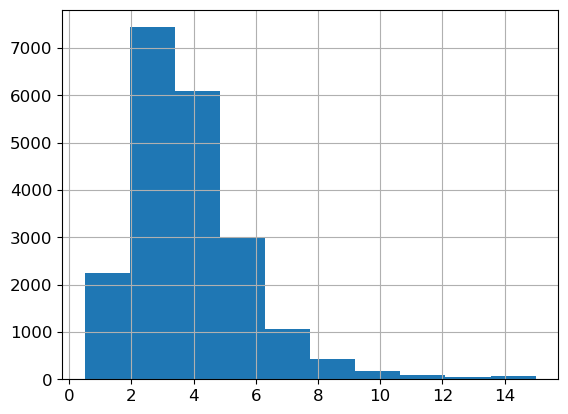

In [24]:
housing["median_income"].hist()

### La estratificación

Como $median\_income$ es un atributo numérico continuo vamos a crear un atributo de categorías de ingresos (de una gradación de 0 a 15 vamos a transformarlo a una gradación de 5 grupos (de 1 a 5, sin decimales)). De esta forma se puede hacer un **muestreo estratificado** basado en la categoría de ingresos, así cuando se realice la división de los datos en conjunto de entrenamiento y prueba esta estratificación va a asegurar que las proporciones se van a seguir manteniendo en esos conjuntos.

La estratificación es importante para evitar sesgos y garantizar que el modelo sea entrenado y evaluado en subconjuntos representativos de las clases o categorías presentes en los datos.

Vamos a crear una nueva columna para realizar la estratificación, en este caso será *income_cat*. Con ella vamos a crear categorías basadas en los valores medios de los ingresos 

In [25]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"]=pd.to_numeric(housing["income_cat"]) #por si están como cadenas

housing=housing.drop(["median_income"], axis=1)

In [26]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

Los valores ahora están un poco más balanceados (dentro de las limitaciones de los datos) y las rentas altas están más agrupadas. La mayoría en categoría 3 que serían ingresos medios, 4 más altos,...

Esto nos da una idea de cómo están distribuidos los ingresos y de la proporción que debemos mantener cuando creemos el set de entrenamiento. 


<Axes: >

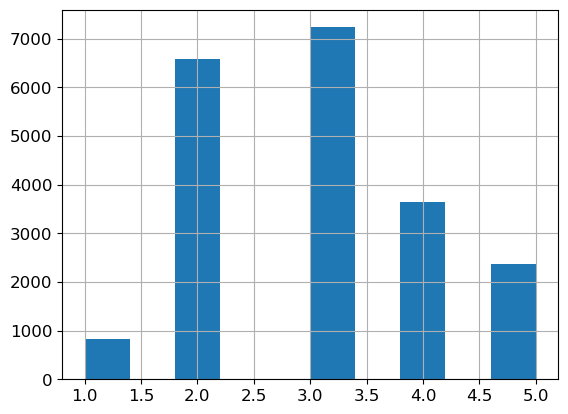

In [27]:
housing["income_cat"].hist()

Con el método de pandas *value_counts()* obtengo la frecuencia de cada valor en la columna indicada. Devuelve una serie que indica la cantidad de veces que aparece en cada categoría, al dividirlos entre el número de filas del conjunto, veo la proporción de cada categoría dentro del conjunto.

In [28]:
housing["income_cat"].value_counts() / len(housing)  #vemos el porcentaje de casas que pertenecen a cada categoría

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

## Limpieza de datos

¿Recuerdas que $total\_bedrooms$ tenía celdas **null**? 


Podrías eliminarlos con:
<code>

housing.dropna(subset=["total_bedrooms"], inplace=True) # opción 1 : borrar nulos

housing.drop("total_bedrooms", axis=1)       # opción 2: eliminar ese dato

#opción 3 : rellenar con mediana :  en este caso como son pocos es el que utilizamos
</code>

[Ver más en proyecto de Aurélien completo]

In [29]:
median = housing["total_bedrooms"].median()

housing["total_bedrooms"].fillna(median, inplace=True) #modifica el dataframe
#housing["total_bedrooms"].fillna(median, inplace=False) #así pasamos una copia
housing.describe()

C:\Users\constantin.madalin.i\AppData\Local\Temp\ipykernel_7724\300092583.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True) #modifica el dataframe


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,income_cat
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,206855.816909,5.429000,0.213039,3.070655,3.006686
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,115395.615874,2.474173,0.057983,10.386050,1.054618
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,14999.000000,0.846154,0.100000,0.692308,1.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,119600.000000,4.440716,0.175427,2.429741,2.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,179700.000000,5.229129,0.203162,2.818116,3.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,264725.000000,6.052381,0.239821,3.282261,4.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,500001.000000,141.909091,1.000000,1243.333333,5.000000


### Atributos de texto y categóricos
¿Recuerdas que $ocean\_proximity$ era de tipo $string$? Sería un dato de tipo categórico. Como los algoritmos de ML prefieren trabajar con números vamos a convertir estas categorías de texto a números

In [30]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


Tenemos distintas posibilidades:

1. Utilizar un LabelEncoder. Esto nos sirve cuando tenemos una sola columna categórica y queremos convertirla a valores numéricos. Por ejemplo, Sexo =hombre,mujer. También cuando las etiquetas son de ese tipo se puede utilizar. 

2. Utilizar un OrdinalEncoder. Se utiliza para características categóricas y puede manejar varias columnas. El orden de las categorías puede tener significado.

3. Hacer un OneHotEncoding 

##### Opción 2. OrdinalEncoder

Lo que sigue es cómo asignar un número a cada etiqueda de $ocean\_proximity$

In [31]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder() #instanciamos la clase

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) 
housing_cat_encoded[:-10]  #quedarían así los valores codificados

array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(20630, 1))

La lista para poder recuperar el nombre de la etiqueta a partir del número:

In [32]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pero existe un problema con esta representación: los algoritmos de ML asumirán que 2 valores cercanos son más similares que 2 distantes y no tiene porqué ser así. Otra forma, mucho mejor, es crear tantas columnas como etiquetas diferentes tiene la columna categórica (en este caso 5) y poner 0 o 1 (false, true) si la instancia tiene o no dicha etiqueta. Esto se llama codificación one-hot.

##### Opción 3. OneHotEncoder

Así no introducimos información nueva y no damos más peso a una o a otra. Pero añadimos columnas.

In [33]:
from sklearn.preprocessing import OneHotEncoder  

cat_encoder = OneHotEncoder() 
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)  #llamamos al método que calcula la matriz
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20640 stored elements and shape (20640, 5)>

Por defecto, `OneHotEncoder` devuelve una matriz dispersa(sparse array (array/matriz con muchos ceros y muy comprimible), pero podemos convertirlo a un array/matriz denso de la siguiente manera:

In [34]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(20640, 5))

Otra forma de hacerlo es poner sparse a False al crear el one-hot-encoder

In [35]:
cat_encoder= OneHotEncoder(sparse_output=False)

housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 

housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(20640, 5))

In [36]:
cat_encoder.categories_  #podemos ver las categorías utilizando la variable de instancia categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [37]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

Ahora podemos sustituir la columna `ocean_proximity` por sus `OneHotEncoder`.

In [38]:
housing.reset_index(drop=False, inplace=True)
housing=housing.join(pd.DataFrame(housing_cat_1hot, columns=[cat for cat in cat_encoder.categories_[0]]))
housing=housing.drop(["ocean_proximity"], axis=1);
housing=housing.rename({"<1H OCEAN":"1H OCEAN"}, axis=1)
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     20640 non-null  int64  
 1   longitude                 20640 non-null  float64
 2   latitude                  20640 non-null  float64
 3   housing_median_age        20640 non-null  float64
 4   total_rooms               20640 non-null  float64
 5   total_bedrooms            20640 non-null  float64
 6   population                20640 non-null  float64
 7   households                20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   rooms_per_household       20640 non-null  float64
 10  bedrooms_per_room         20433 non-null  float64
 11  population_per_household  20640 non-null  float64
 12  income_cat                20640 non-null  int64  
 13  1H OCEAN                  20640 non-null  float64
 14  INLAND

In [39]:
housing.head()  #ahí vemos como solo tenemos 0 o 1 en las columnas creadas

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,income_cat,1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,452600.0,6.984127,0.146591,2.555556,5,0.0,0.0,0.0,1.0,0.0
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,358500.0,6.238137,0.155797,2.109842,5,0.0,0.0,0.0,1.0,0.0
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,352100.0,8.288136,0.129516,2.802260,5,0.0,0.0,0.0,1.0,0.0
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,341300.0,5.817352,0.184458,2.547945,4,0.0,0.0,0.0,1.0,0.0
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,342200.0,6.281853,0.172096,2.181467,3,0.0,0.0,0.0,1.0,0.0


## Creamos el Test Set

Vamos a crear los datos necesarios para el entrenamiento y la evaluación del modelo.

Como vamos a trabajar con numeros aleatorios, plantaremos una semilla estocástica, esto es, vamos a inicializar el generador de números aleatorios con un número, de tal forma que siempre nos proporcionará la misma secuencia de números aleatorios si empezamos con la misma semilla.

In [40]:
# ¿por qué 42? https://es.wikipedia.org/wiki/El_sentido_de_la_vida,_el_universo_y_todo_lo_demás
np.random.seed(42)

La siguiente función se encarga de dividir (split) los datos en dos subconjuntos con un ratio indicado (80%, 20% por ejemplo).

Aurélien lo hace de forma un poco,... complicada, pero muy efectiva:

1. Primero obtiene una permutación de los índices (*shuffled*=barajado).
2. Para después quedarse con un porcentaje para el **train set** y el restante para el **test set**.
3. La función devuelve ambos conjuntos de datos.


Típicamente se suele hacer:

<code>
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
</code>

In [41]:
# divide los datos en train y set sets.
def split_train_test(data, test_ratio):
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Seguidamente usamos la función y mostramos el tamaño de cada conjunto separado de los datos iniciales.

In [42]:
X_train, X_test = split_train_test(housing, 0.2)
len(X_train)

16512

In [43]:
len(X_test)

4128

In [44]:
X_test.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,income_cat,1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
20046,20046,-119.01,36.06,25.0,1505.0,435.0,1392.0,359.0,47700.0,4.192201,NaN,3.877437,2,0.0,1.0,0.0,0.0,0.0
3024,3024,-119.46,35.14,30.0,2943.0,435.0,1565.0,584.0,45800.0,5.039384,NaN,2.679795,2,0.0,1.0,0.0,0.0,0.0
15663,15663,-122.44,37.80,52.0,3830.0,435.0,1310.0,963.0,500001.0,3.977155,NaN,1.360332,3,0.0,0.0,0.0,1.0,0.0
20484,20484,-118.72,34.28,17.0,3051.0,435.0,1705.0,495.0,218600.0,6.163636,NaN,3.444444,4,1.0,0.0,0.0,0.0,0.0
9814,9814,-121.93,36.62,34.0,2351.0,435.0,1063.0,428.0,278000.0,5.492991,NaN,2.483645,3,0.0,0.0,0.0,0.0,1.0


Volvemos al **train set**. 
* Para trabajar con los datos, con el objetivo de entrenar un modelo, primero separamos las columnas predictoras de la columna a predecir 
* Para después hacer limpieza de los primeros.

In [45]:
y_train = X_train["median_house_value"].copy()
X_train = X_train.drop("median_house_value", axis=1)  


En este caso, como  parece que hay una relación con los ingresos medios, hemos visto antes cómo podíamos estratificar nuestros datos. Scikit-Learn tiene varias clases de divisiones en el paquete *sklearn.model_selection* y en este caso vamos a utilizar *StratifiedShuffleSplit* que nos permite dividir el conjunto de datos en entrenamiento y prueba teniendo en cuenta un modelo estratificado. En este ejemplo solo creamos una partición (n_splits=1) si quisiésemos crear varios conjuntos de entrenamiento y prueba, tendríamos simplemente que modificar ese valor.

Con esta estratificación nos aseguramos que la distribución de la columna "income_cat",que representaba la categoría de ingresos, se va a mantener igual en el conjunto de entrenamiento y en el de prueba e iguales a las del conjunto original. Está haciendo una *división estratificada* asegurándose de que las proporciones en el conjunto de entrenamiento y prueba son iguales.

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):  #que se mantenga proporcional "income_cat"
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

<Axes: xlabel='longitude', ylabel='latitude'>

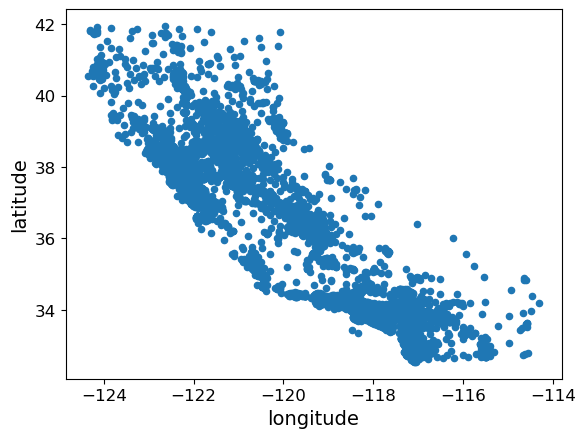

In [47]:
strat_train_set.plot(kind="scatter", x="longitude", y="latitude")

Así puede verse que las proporciones entre los datos originales y el estratificado se conservan

In [48]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [49]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

Por último eliminamos la columna (axis=1) que ya no necesitamos de ambos conjuntos, recordamos que la creamos para simplemente crear los conjuntos estratificados

In [50]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [51]:
y_train2=strat_train_set["median_house_value"].copy()

In [52]:
y_train2.head()

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64

# Seleccionar y entrenar el modelo
(aquí se ha hecho con el original, prueba con el estratificado)

## Entrenando y evaluando el modelo de **train_set**

**Regresión lineal múltiple**

En este caso nuestra regresión lineal utiliza varias variables para predecir 

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

Vamos a probarlo en el conjunto de entrenamiento, fijándonos en las 5 primeras predicciones y comparándolas con las etiquetas

In [54]:
some_data = X_train.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))

some_labels = y_train.iloc[:5]
print("Labels:", list(some_labels))

Predictions: [210112.60160566 290080.10905652 237434.87979008 160676.41032696
 169806.0889646 ]
Labels: [103000.0, 382100.0, 172600.0, 93400.0, 96500.0]


Vamos a utilizar una función de pérdida (o también llamada de error) como es el  <a href="https://developers.google.com/machine-learning/crash-course/linear-regression/loss?hl=es-419"> Error Cuadrático Medio(MSE)</a> para medir el rendimiento y la precisión del modelo.

Ya podemos ver que estas predicciones están desviadas pero vamos a medirlas utilizando el Error Cuadrático Medio de este modelo en todo el conjunto de entrenamiento. Utilizamos la función *mean_squared_error*

In [55]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(X_train)  
lin_mse = mean_squared_error(y_train, predictions) #error cuadrático medio ECM o MSE
lin_rmse = np.sqrt(lin_mse)     # Raíz de ECM (RECM) o RMSE
"""Raíz cuadrada del error cuadrático medio, es más fácil de interpretar porque está en las mismas unidades que los datos originales"""
lin_rmse

np.float64(72466.29596009899)

Observamos cuánto varía en $ (mucho). Vamos a utilizar el Error Absoluto Medio (MAE) que nos da la media de las diferencias absolutas entre los valores reales y los que hemos predicho. No penaliza tanto los errores grandes y es menos sensible a los outliers. 

In [56]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, predictions)
lin_mae

54496.70804419881

Aún así vemos que es demasiado. Así que vamos a probar con otros modelos. 

**Decision Tree**

In [57]:
from sklearn.tree import DecisionTreeRegressor   

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)      #entrenamos 

DecisionTreeRegressor(random_state=42)

Ahora que está entrenado, lo evaluamos con el conjunto de entrenamiento y comprobamos de nuevo el MSE

In [58]:
predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

**Error 0!!!**

Pero no cantemos victoria. Estamos evaluando con el mismo dataset que hemos empleado para entrenar el modelo. 

Esto es, básicamente, hacer trampa. Necesitamos utilizar parte del conjunto de datos para entrenar y parte para validar

## Usando la Cross-Validation

Vamos a usar un medio de evaluación del modelo sin usar, aún, el testset. Podemos utilizar la característica de validación cruzada de Scikit-Learn. 

En este ejemplo se divide de manera aleatoria el conjunto de entrenamiento en 10 subconjuntos no solapados y después entrena y evalúa el modelo del árbol de decisiones 10 veces, el resultado es una matriz que contiene las 10 puntuaciones de evaluación.

Las características de validación cruzada de Sklearn esperan una función de utilidad (cuanto mayor sea, mejor), más que una función de pérdida(cuanto menor sea, mejor), así que, la función de puntuación es lo contrario a la MSE (por eso cambiamos el signo).

In [59]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
#scoring nos da la métrica a utilizar, en este caso como es regresión puede ser:
# neg_mean_squared_error,neg_mean_absolute_error o r2 o incluso una propia
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([69900.27555949, 69917.29334119, 66818.61867301, 68875.61264955,
       71540.74537282, 68474.65840833, 69822.75606482, 69345.03237611,
       68476.39072897, 67367.21370266])

In [60]:
pd.Series(tree_rmse_scores).describe()

count       10.000000
mean     69053.859688
std       1368.872800
min      66818.618673
25%      68475.091488
50%      69110.322513
75%      69880.895686
max      71540.745373
dtype: float64

Si comparamos ahora los 2 modelos no parece que ya haya tanta diferencia...La validación cruzada permite obtener además de la estimación del rendimiento del modelo también una medida de lo precisa que es la estimación(su desviación estándar).
Parece en este caso que el rendimiento del Decision Tree es un poco mejor que el del modelo lineal, pero no tanto. 

In [61]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69900.27555949 69917.29334119 66818.61867301 68875.61264955
 71540.74537282 68474.65840833 69822.75606482 69345.03237611
 68476.39072897 67367.21370266]
Mean: 69053.85968769508
Standard deviation: 1298.6267626066976


In [62]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69956.90125981 76664.26551146 70495.35619822 70738.05620993
 73347.14098355 71020.33855508 70921.19634339 71362.91940785
 77049.90056676 75205.43946791]
Mean: 72676.15145039753
Standard deviation: 2556.067776637088


**Random Forest**

Funciona entrenando muchos árboles de decisiones en subconjuntos aleatorios de características y haciendo una media de sus predicciones cuando se trata como en este caso de una regresión o escogiendo la clase más votada si se trata de una clasificación.

In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [64]:
predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18316.335844790185)

Bueno!, un valor mejor de RMSE (más bajo). Y la validación cruzada...

In [65]:
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [47793.68220893 50027.4114661  48079.47384622 50472.79453833
 51113.01982409 48116.39511355 49514.29541387 50601.80185073
 48772.37925606 50003.75485174]
Mean: 49449.500836960266
Standard deviation: 1124.3653045576818


El mejor de los que hemos probado.

Observa lo que pasa con otros modelos... El objetivo es seleccionar algunos modelos prometedores para luego ajustarlos.

**Support Vector Regression** 

Este modelo es una versión de SVM (Support Vector Machine: Máquina de vector soporte) aplicada a regresión. 

In [66]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)
predictions = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(100212.13117406932)

**XGBoost**

Combina varios árboles de decisión. Pero en este caso los árboles se construyen de manera secuencial. Cada árbol intenta corregir los errores de los árboles anteriores.

In [67]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42) 
#indica tanto el tipo de problema(regresión) como la función de pérdida que utiliza(mse)

xgb_reg.fit(X_train, y_train)
predictions = xgb_reg.predict(X_train)
xgb_mse = mean_squared_error(y_train, predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse


ModuleNotFoundError: No module named 'xgboost'

In [150]:
xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores: [53115.87977918 55443.62770505 53217.49702401 53165.63692101
 56870.21627642 51559.75701215 51123.14143151 55172.76725684
 54321.6394751  56017.71661219]
Mean: 54000.78794934568
Standard deviation: 1794.2534329363707


Para ver todos los ítems de *02_end_to_end_machine_learning_project.ipynb* de Aurélien, falta por comentar:

- Escalado de características y transformación
- Transformadores personalizados
- Pipelines de transformación

Y a la hora de realizar el ajuste del modelo a través de sus hiperparámetros:

- GridSearchCV
- RandomizedSearchCV , analizando los mejores modelos y sus errores

Por último, una vez evaluado en el conjunto de prueba, quedaría lanzar, monitorizar y mantener el sistema utilizando la librería *joblib*
